<a href="https://colab.research.google.com/github/poo5zan/Autoformer/blob/main/Autoformer_Research_project_Pujan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/My Drive/Research Project/datasets'
results_path = '/content/drive/My Drive/Research Project/results/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone -b pujan_changes https://github.com/poo5zan/Autoformer.git


fatal: destination path 'Autoformer' already exists and is not an empty directory.


In [ ]:
import sys
if not 'Autoformer' in sys.path:
    sys.path += ['Autoformer']

In [ ]:
!pip install reformer_pytorch

In [ ]:
import shutil
import os
def remove_directory(dir_path):
    if os.path.exists(dir_path):
        print('removing directory ', dir_path)
        shutil.rmtree(dir_path)

remove_directory('results')
remove_directory('checkpoints')
remove_directory('Autoformer_old')

removing directory  results
removing directory  checkpoints


In [ ]:
def make_directory(dir_path):
    if not os.path.exists(dir_path):
        print('creating dir ', dir_path)
        os.mkdir(dir_path)

make_directory(results_path)
make_directory(results_path + "TEST")

Args in experiment:
{'learning_rate': 1e-05, 'train_epochs': 20, 'root_path': '/content/drive/My Drive/Research Project/datasets', 'model': 'Autoformer', 'data': 'custom', 'target': 'stock_0_y', 'data_path': 'stock_data_tcn_targets.csv', 'model_id': 'run_2', 'features': 'M', 'enc_in': 9, 'dec_in': 9, 'c_out': 9, 'des': 'Exp', 'dropout': 0.05, 'num_workers': 0, 'gpu': 0, 'lradj': 'type1', 'devices': '0', 'use_gpu': True, 'use_multi_gpu': True, 'freq': 'h', 'checkpoints': './checkpoints/', 'bucket_size': 4, 'n_hashes': 4, 'is_trainging': True, 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'e_layers': 2, 'd_layers': 1, 'n_heads': 8, 'factor': 1, 'd_model': 512, 'itr': 1, 'd_ff': 2048, 'distil': True, 'output_attention': False, 'patience': 3, 'batch_size': 32, 'embed': 'fixed', 'activation': 'gelu', 'use_amp': False, 'loss': 'mse', 'moving_avg': 25}
Use GPU: cuda:0
>>>>>>>start training : run_2_Autoformer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebfixed_dtTrue_Exp_0>>>>>>>>

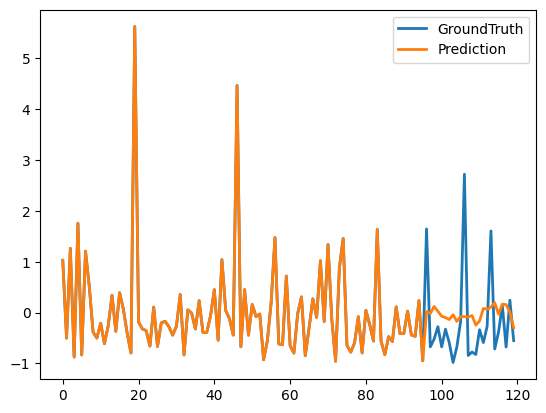

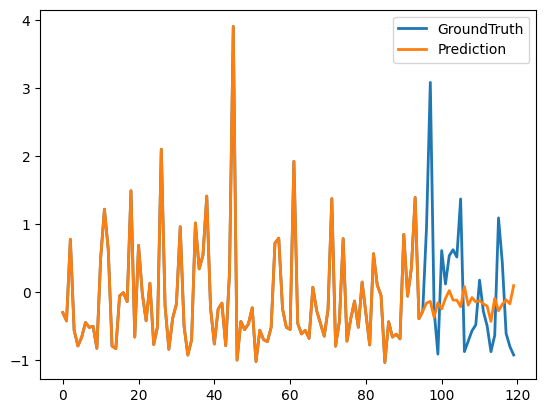

In [ ]:
import argparse
import torch
from exp.exp_main import Exp_Main#exp stands for experiments
import random
import numpy as np
from utils.tools import dotdict
import pandas as pd

import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import numpy as np

%matplotlib inline

fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

def run_experiment(args: dotdict):
    args.des = 'test'
    args.dropout = 0.05
    args.num_workers = 0
    args.gpu = 0
    args.lradj = 'type1'
    args.devices = '0'
    args.use_gpu = True
    args.use_multi_gpu = True
    args.freq = 'h'
    args.checkpoints = './checkpoints/'
    args.bucket_size = 4
    args.n_hashes = 4
    args.is_trainging = True
    args.seq_len = 96
    args.label_len = 48
    args.pred_len = 24
    args.e_layers = 2
    args.d_layers = 1
    args.n_heads = 8
    args.factor = 1
    args.d_model = 512
    args.des = 'Exp'
    args.itr = 1
    args.d_ff = 2048
    args.distil = True
    args.output_attention = False
    args.patience= 3
    args.batch_size = 32
    args.embed = 'fixed'
    args.activation = 'gelu'
    args.use_amp = False
    args.loss = 'mse'

    # new configs
    args.moving_avg = 25

    print('Args in experiment:')
    print(args)

    Exp = Exp_Main

    os.environ["CUDA_VISIBLE_DEVICES"] = '0'

    error_metrics = {}
    losses = None
    setting = ''
    for ii in range(args.itr):#itr就是实验次数可不是epoch，parser.add_argument('--itr', type=int, default=2, help='experiments times')
        # setting record of experiments
        setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
            args.model_id,
            args.model,
            args.data,
            args.features,
            args.seq_len,
            args.label_len,
            args.pred_len,
            args.d_model,
            args.n_heads,
            args.e_layers,
            args.d_layers,
            args.d_ff,
            args.factor,
            args.embed,
            args.distil,
            args.des, ii)

        make_directory(results_path + setting)

        exp = Exp(args)  # set experiments

        print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
        losses = exp.train(setting)#setting是用来保存模型的名字用的，很细节

        print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        error_metrics = exp.test(setting)
        # torch.cuda.empty_cache()
        # print(3)
        print('end one iteration')

    # custom data: xxx.csv
    # data features: ['date', ...(other features), target feature]

    # we take ETTh2 as an example #模仿informer 的 colab example的custom_dataset与predict部分
    # import pandas as pd
    # exp.args.root_path = './dataset/ETT-small/'
    # exp.args.data_path = 'ETTh2.csv'

    # df = pd.read_csv(os.path.join(args.root_path, args.data_path))

    args.do_predict = True
    if args.do_predict:
        print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        prediction=exp.predict(setting, True)#data_factory做好了pred里面的batch_size=1的情况，是autoformer在informer基础之上做的
        # torch.cuda.empty_cache()
        # print(prediction.shape)

    return error_metrics, losses, setting

args = dotdict()
args.learning_rate = 0.00001
args.train_epochs = 20
# args.root_path = '/Users/pujanmaharjan/uni adelaide/research project/Informer/dataset/'
args.root_path = root_path
args.model = 'Autoformer'
args.data = 'custom'

run_1 = False
run_2 = True
run_3= False

error_metrics_all = []
losses_all = []

# run 1
if run_1:
    args.target = 'stock_0'
    args.data_path ='stock_data_targets.csv'
    args.model_id='run_1'
    args.features = 'M'
    feature_count = len(pd.read_csv(os.path.join(args.root_path, args.data_path)).columns) - 1
    args.enc_in = feature_count
    args.dec_in = feature_count
    args.c_out = feature_count
    error_metrics_run_1, losses_run_1, setting = run_experiment(args)
    error_metrics_all.append(error_metrics_run_1)
    losses_all.append(losses_run_1)

# run 2
if run_2:
    args.target = 'stock_0_y'
    args.data_path ='stock_data_tcn_targets.csv'
    args.model_id='run_2'
    args.features = 'M'
    feature_count = len(pd.read_csv(os.path.join(args.root_path, args.data_path)).columns) - 1
    args.enc_in = feature_count
    args.dec_in = feature_count
    args.c_out = feature_count
    error_metrics_run_2, losses_run_2, setting = run_experiment(args)
    error_metrics_all.append(error_metrics_run_2)
    losses_all.append(losses_run_2)


# run 3
if run_3:
    args.data_path = 'stock_0_features.csv' #'output.csv' # data file
    args.target = 'target' # target feature in S or MS task
    args.features = 'MS'
    args.model_id='run_3'
    feature_count = len(pd.read_csv(os.path.join(args.root_path, args.data_path)).columns) - 1
    args.enc_in = feature_count
    args.dec_in = feature_count
    args.c_out = 1
    error_metrics_run_3, losses_run_3, setting = run_experiment(args)
    error_metrics_all.append(error_metrics_run_3)
    losses_all.append(losses_run_3)








In [ ]:
def plot_predictions(trues, preds, start_index, step, num_plots, setting):
        num_rows = num_plots // 3
        num_cols = 3

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 3 * num_rows), sharex=True, sharey=True)

        for i, ax in enumerate(axes.flatten()):
            if i < num_plots:
                index = start_index + i * step

                ax.plot(trues[index, :, -1], label='GroundTruth')
                ax.plot(preds[index, :, -1], label='Prediction')

                ax.set_title(f'Index {index}')
                ax.legend()
                ax.set_xlabel('time')
                ax.set_ylabel('Realized volatility')
                ax.tick_params(axis='both', which='both', labelsize=8, direction='in')

            else:
                ax.axis('off')


        plt.tight_layout()
        fig.savefig(results_path + setting+'/prediction_plot.png')
        plt.show()
        plt.close(fig)

def plot_graph(results_data_path):

    # data_pred = np.load('./results/ETTh1_96_24_Autoformer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
    data_pred = np.load(os.path.join(results_data_path, 'real_prediction.npy'))
    data_pred = torch.from_numpy(data_pred).permute(0,2,1)

    plt.figure()
    # print(data_pred.shape)
    #预测OT
    plt.plot(data_pred[-1,-1,:])#由于prediction.shape是[1,24,7]那么batch只有1 索引只能是0或-1 都是代表batch这一维本身,如果是加载np文件就不一样了
    # print(data_pred[-1,-1,:].shape)
    # plt.show()
    plt.plot(data_pred[0,-1,:])#没问题
    # print(data_pred[0,-1,:].shape)
    # plt.show()
    # draw HUFL prediction
    plt.plot(data_pred[0,0,:])#没问题
    # print(data_pred[-1,-1,:].shape)
    # plt.show()
    '''
    Ground Truth
    '''
    data_gt = np.load(os.path.join(results_data_path, 'true.npy'))
    data_gt = torch.from_numpy(data_gt).permute(0,2,1)

    #预测OT
    plt.plot(data_gt[-1,-1,:])#由于prediction.shape是[1,24,7]那么batch只有1 索引只能是0或-1 都是代表batch这一维本身,如果是加载np文件就不一样了
    # print(data_gt[-1,-1,:].shape)
    # plt.show()
    plt.plot(data_gt[0,-1,:])#没问题
    # print(data_gt[0,-1,:].shape)
    # plt.show()
    # draw HUFL prediction
    plt.plot(data_gt[0,0,:])#没问题
    # print(data_gt[-1,-1,:].shape)
    plt.savefig('./results/fig.png')
    plt.show()



# results_path = './results/stock_data_tcn_targets_Autoformer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebfixed_dtTrue_Exp_0'
# plot_graph(results_path)
#
# search_dir = "./checkpoints/"
# dirs = os.listdir(search_dir)
# dir_list = []
# for d in dirs:
#     if d.lower() == '.ds_store':
#         continue
#     date_change = os.path.getmtime(search_dir + d)
#     dir_list.append({'directory_name': d, 'changed_date': date_change})

# setting = sorted(dir_list, key=lambda x: x['changed_date'], reverse=True)[0]['directory_name']
print('setting folder ', setting)

print('error metrics all ', error_metrics_all)
error_metrics_df = pd.DataFrame(error_metrics_all)
print(error_metrics_df)
error_metrics_df.to_csv(results_path + setting + "/error_metrics.csv", index=False)

losses_df = pd.DataFrame(losses_all[0])
losses_df.to_csv(results_path + setting + "/losses.csv", index=False)

preds = np.load("./results/"+setting+'/pred.npy')
trues = np.load("./results/"+setting+'/true.npy')

setting folder  run_2_Autoformer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebfixed_dtTrue_Exp_0
error metrics all  [{'mae': 0.7740848, 'mse': 1.0108957, 'rmse': 1.0054331, 'mape': 1.4943576, 'mspe': 85.35966}]
        mae       mse      rmse      mape       mspe
0  0.774085  1.010896  1.005433  1.494358  85.359657


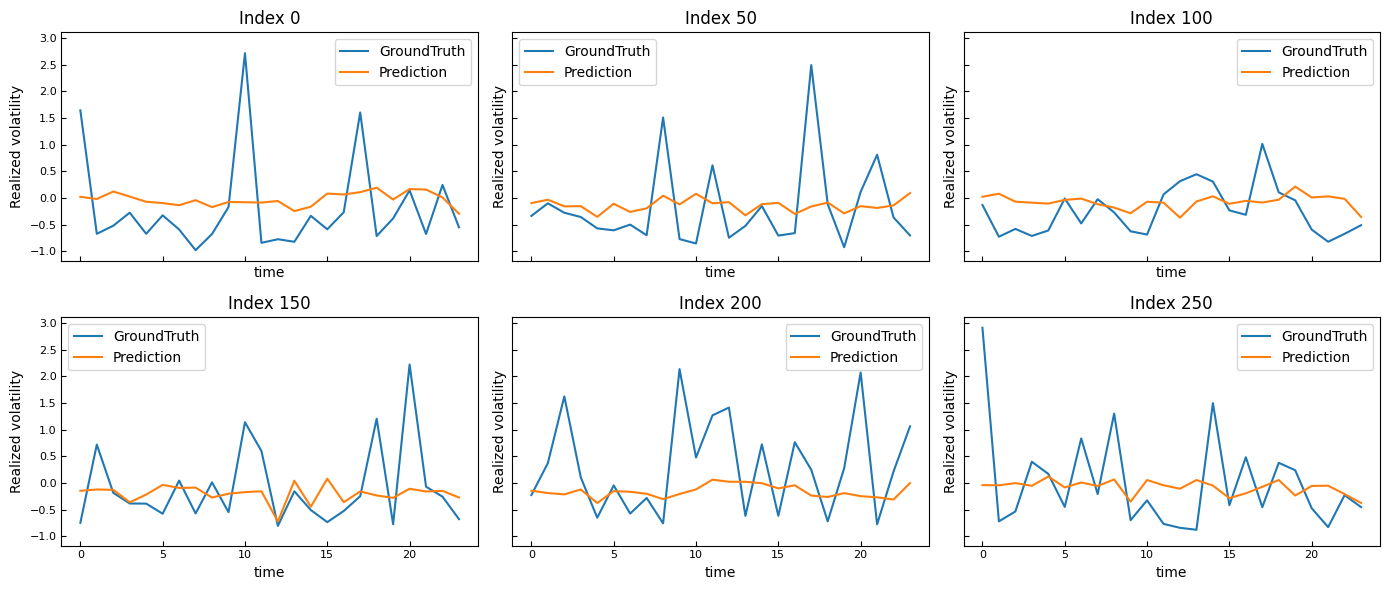

In [ ]:
plot_predictions(trues, preds, start_index=0, step=50, num_plots=6, setting = setting)

[{'epoch': 1, 'train_steps': 80, 'train_loss': 1.1023792400956154, 'validation_loss': 1.0173126, 'test_loss': 1.0221068, 'cost_time': 8.497822284698486}, {'epoch': 2, 'train_steps': 80, 'train_loss': 1.0273730628192426, 'validation_loss': 1.0122901, 'test_loss': 1.0154262, 'cost_time': 8.294527530670166}, {'epoch': 3, 'train_steps': 80, 'train_loss': 1.0124207526445388, 'validation_loss': 1.0040332, 'test_loss': 1.0099506, 'cost_time': 8.131803512573242}, {'epoch': 4, 'train_steps': 80, 'train_loss': 1.0074958495795727, 'validation_loss': 1.0052301, 'test_loss': 1.0083075, 'cost_time': 8.016707420349121}, {'epoch': 5, 'train_steps': 80, 'train_loss': 1.0042218841612338, 'validation_loss': 1.0058293, 'test_loss': 1.0075818, 'cost_time': 7.906926393508911}, {'epoch': 6, 'train_steps': 80, 'train_loss': 1.0026945799589158, 'validation_loss': 1.0030785, 'test_loss': 1.0081445, 'cost_time': 8.11930799484253}, {'epoch': 7, 'train_steps': 80, 'train_loss': 1.0026727348566056, 'validation_loss

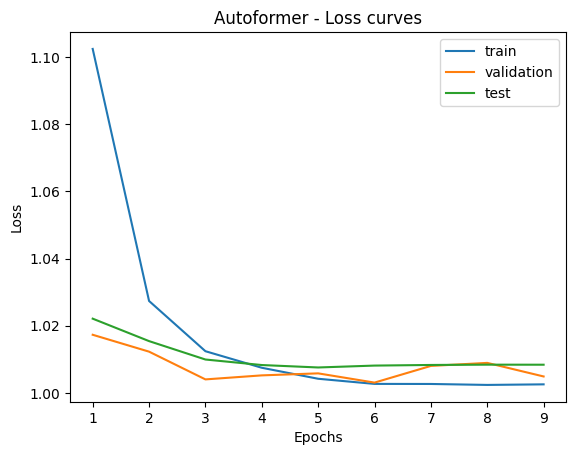

end


In [ ]:

def drawplots(epochs, train_loss, validation_loss, test_loss,title,setting):
    import matplotlib.pyplot as plt1
    plt1.plot(epochs, train_loss, label="train")
    plt1.plot(epochs, validation_loss, label="validation")
    plt1.plot(epochs, test_loss, label="test")
    plt1.title(title)
    plt1.legend()
    plt1.xlabel('Epochs')
    plt1.ylabel('Loss')

    # plt.close(fig)

    plt1.savefig(results_path + setting + "/" + title + '.png')
    plt1.show()

def drawplot(epochs, losses, title, setting):
    # fig, ax = plt.subplots()
    import matplotlib.pyplot as plt2
    plt2.plot(epochs, losses)
    plt2.title(title)
    plt2.xlabel('Epochs')
    plt2.ylabel('Loss')

    # plt.close(fig)

    plt2.savefig(results_path + setting + "/" + title + '.png')
    plt2.show()

# print(losses)
first_loss = losses_all[0]
print(first_loss)
epochs = [f['epoch'] for f in first_loss]
print(epochs)
train_losses = [f['train_loss'] for f in first_loss]
validation_losses = [f['validation_loss'] for f in first_loss]
test_losses = [f['test_loss'] for f in first_loss]
drawplots(epochs, train_losses, validation_losses, test_losses, 'Autoformer - Loss curves', setting)


print('end')

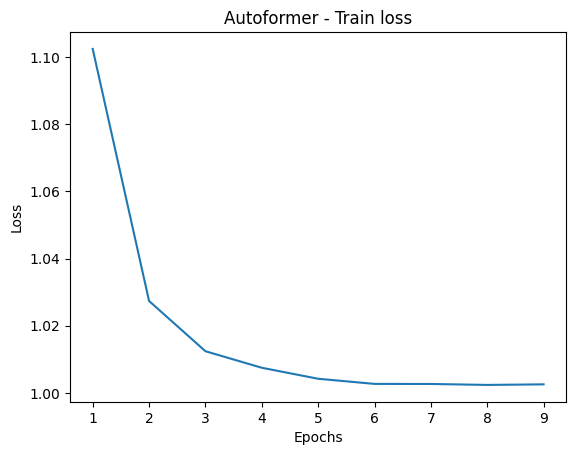

In [ ]:
drawplot(epochs, train_losses, 'Autoformer - Train loss', setting)


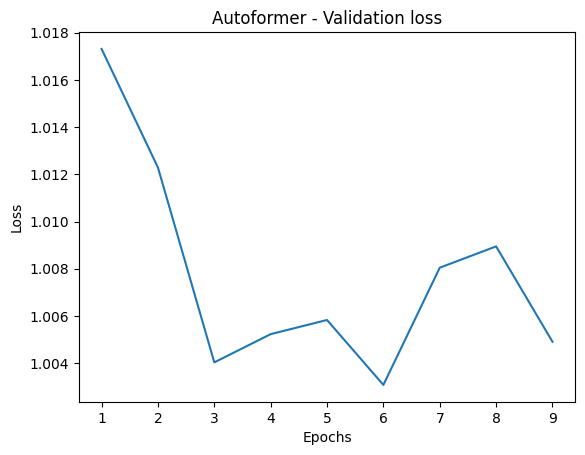

In [ ]:
drawplot(epochs, validation_losses, 'Autoformer - Validation loss', setting)


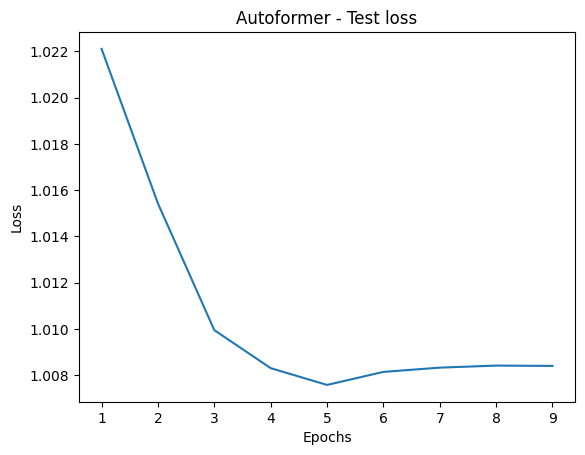

In [ ]:
drawplot(epochs, test_losses, 'Autoformer - Test loss', setting)